# **Introduction - Extraite du read me**

Un récent rapport du Sénat [1](#1) (29 mars 2022) met en évidence une dégradation très alarmante de l’accès aux soins en France. Chaque année, près de 1,6 million de Français renoncent à des soins médicaux, tandis qu’environ un tiers de la population vivrait dans un « désert médical ».

Si le terme de *désert médical* est aujourd’hui omniprésent dans le débat public, il ne repose pourtant pas sur une définition précise. Il suggère ainsi une vision trop simplifiée de l’accès aux soins en France, opposant des territoires supposés totalement dépourvus d’offre médicale à d’autres beaucoup mieux lotis. Une telle approche masque la complexité des situations locales et soulève un enjeu méthodologique majeur : sur quelle réalité statistique et démographique fonder la notion de désert médical ? Celle d’un seuil ? Concerne-t-il uniquement les médecins généralistes, ou faut-il également intégrer les médecins spécialistes, les autres professionnels de santé, l’offre hospitalière, l’accès aux urgences ou encore aux pharmacies ?

Si les déserts médicaux n’existent pas à proprement parler d’un point de vue administratif, ils n’en constituent pas moins une réalité du terrain. En effet, toujours selon ce même rapport du Sénat, plus d’un Français sur dix n’a pas de médecin traitant, alors même que le nombre de médecins est en constante augmentation.

Face à ces constats, il apparaît nécessaire de dépasser le simple diagnostic des inégalités d’accès aux soins pour s’intéresser aux facteurs territoriaux sous-jacents. En particulier, comprendre les déterminants de l’implantation des médecins permet d’éclairer les mécanismes à l’origine des situations de faible accessibilité observées dans certaines communes.

#### Problématique

Comment les caractéristiques des territoires déterminent-elles le choix d’implantation des médecins, et dans quelle mesure participent-elles aux situations de faible accessibilité aux soins dans certaines communes ?

### Objectif et méthodologie

Notre objectif est de mettre en évidence l'existence de ces *déserts médicaux*, d'analyser les déterminants de l'installation des médecins et de comprendre les raisons de ces situations de faible accessibilité aux soins.

Notre approche se scinde en trois phases
  1) Récupération des données
  2) Statistique et étude descriptive, pour la mise en évidence des déserts
  3) Modélisation, pour l'interprétation des causes de l'apparition des déserts

# **I. Préparation de l'espace de travail**

## **1. Importations des modules et bibliothèques**

### **1.a. Bibliothèques de base.**

In [1]:
# Installation des modules nécessaires à l'exécution du code

!pip install openpyxl cartiflette mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 58.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [cartiflette] [openpyxl]


In [2]:
# Import des bibliothèques utilisés pour la lecture des données et les statistiques descriptives 

import openpyxl 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from cartiflette import carti_download
import mapclassify
import plotly.express as px

### **1.b. Bibliothèques liées à la modélisation**

In [3]:
import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import lasso_path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV

## **2. Lecture et nettoyage des différentes bases de données**

### **2.a. Base de la démographie des médecins : demographie_medecins.xslx**

In [4]:
# Import des bases de données depuis "Bases de données/"

df_medecins_effectif_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=1)
df_medecins_age_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=2)
df_medecins_densite_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=3)
df_medecins_secteur = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=6)

In [5]:
# Création de plusieurs bases de données réduites (MG = médecins généralistes).

# 1. Base des effectifs des médecins généralistes.
df_MG_effectif = df_medecins_effectif_complet[
    (df_medecins_effectif_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_effectif_complet['specialites'] == '00-Ensemble')
    ]

df_MG_effectif.drop(axis = 1, columns = ['specialites', 'specialites_agregees'], inplace = True)
df_MG_effectif.reset_index(drop = True, inplace = True)

# 2. Base des âges moyens des médecins généralistes (ici, on ne considérera pas le sexe).
df_MG_age = df_medecins_age_complet[
    (df_medecins_age_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_age_complet['sexe'] == '0-Ensemble')
    & (df_medecins_age_complet['specialites'] == '00-Ensemble')
    ]

df_MG_age.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_MG_age.reset_index(drop = True, inplace = True)

# 3. Base des densités de médecins généralistes (ici, on ne considérera pas le sexe).
df_MG_densite = df_medecins_densite_complet[
    (df_medecins_densite_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_densite_complet['sexe'] == '0-Ensemble')
    & (df_medecins_densite_complet['specialites'] == '00-Ensemble')
]

df_MG_densite.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_MG_densite.reset_index(drop = True, inplace = True)

/tmp/ipykernel_4658/3673678324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MG_effectif.drop(axis = 1, columns = ['specialites', 'specialites_agregees'], inplace = True)
/tmp/ipykernel_4658/3673678324.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MG_age.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
/tmp/ipykernel_4658/3673678324.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

### **2.b. Base de l'indicateur APL (Accessibilité Potentielle Localisée) : APL_2015_2022.xlsx et APL_2022_2023.xlsx**

Cet indicateur est une mesure de l'accessibilité aux médecins libéraux, qui tient compte du niveau d'activité des médecins (offre) et du niveau de recours de la population (demande). Il est construit au niveau communal mais prend en compte l'offre et la demande des communes voisines, dans un certain périmètre.

Pour son calcul, on définit une zone de recours et une zone de patientèle. Les médecins sont comptés en ETP (équivalent temps plein), afin de prendre en compte leur activité annuelle.

L'APL nous donne finalement le nombre d'ETP des médecins généralistes libéraux pour 100 000 habitants, ce qui se traduit en le nombre de consultations accessibles par an par habitant.

Les données de 2015 à 2021 n'utilisent pas exactement la même méthode que de 2022 à 2023, donc ces données ne sont pas parfaitement comparables.

In [6]:
# Lecture des feuilles de la table APL_2022_2023 : valeurs de l'indicateur en 2022 et 2023.
df_APL_2022 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=1)[8:]
df_APL_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=2)[8:]

# Lecture des feuilles de la table APL_2015_2022 (on exclut l'année 2022 en considérant que les données de APL_2022_2023 sont plus pertinentes)
df_APL_2015 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=1)[8:]
df_APL_2016 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=2)[8:]
df_APL_2017 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=3)[8:]
df_APL_2018 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=4)[8:]
df_APL_2019 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=5)[8:]
df_APL_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=6)[8:]

In [7]:
# Nettoyage et renommage des colonnes des bases 2022 et 2023.
bases = [df_APL_2022, df_APL_2023]
annee = 2022

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"APL_{annee}_moins_62", f"APL_{annee}_moins_60", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1

# Nettoyage et renommage des colonnes des bases 2015 à 2021.
bases = [df_APL_2015,df_APL_2016,df_APL_2017,df_APL_2018,df_APL_2019,df_APL_2021]
annee = 2015

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1
    if annee == 2020 : 
        annee += 1

# Jointure des bases en une base APL commune.
bases.append(df_APL_2022)
df_APL = df_APL_2023
for base in bases : 
    df_APL = df_APL.merge(base, how='left', on=["Code commune INSEE", "Commune"])

df_APL

,Code commune INSEE,Commune,APL_2023,APL_2023_moins_65,APL_2023_moins_62,APL_2023_moins_60,population_standard_2021,population_totale_2021,APL_2015,APL_2015_moins_65,...,APL_2021,APL_2021_moins_65,population_standard_2019,population_totale_2019,APL_2022,APL_2022_moins_65,APL_2022_moins_62,APL_2022_moins_60,population_standard_2020,population_totale_2020
0,01001,L'Abergement-Clémenciat,1.942,1.881,1.623,1.455,838.154,832,NaN,NaN,...,2.15,2.076,775.023,779,1.89,1.828,1.799,1.491,810.855,806
1,01002,L'Abergement-de-Varey,2.376,1.767,1.503,1.333,255.723,267,NaN,NaN,...,2.505,2.19,252.742,256,2.649,2.059,1.83,1.493,250.962,262
2,01004,Ambérieu-en-Bugey,3.083,2.431,2.136,1.855,14575.887,14854,4.42,4.324,...,3.367,3.102,13796.994,14134,3.646,2.88,2.697,2.253,14002.685,14288
3,01005,Ambérieux-en-Dombes,3.706,3.648,3.015,2.998,1852.496,1897,4.24,4.24,...,4.303,4.303,1717.427,1751,3.978,3.959,3.312,3.041,1733.232,1782
4,01006,Ambléon,0.889,0.775,0.648,0.57,121.314,113,1.103,0.926,...,0.917,0.793,117.329,112,0.926,0.796,0.746,0.588,121.438,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,97420,Sainte-Suzanne,3.764,3.235,2.64,2.36,22314.19,24293,4.269,3.799,...,3.732,3.156,22206.544,24065,3.701,3.096,2.588,2.151,21899.922,24086
34950,97421,Salazie,3.354,2.465,1.576,1.576,6748.4,7243,2.079,1.774,...,4.167,3.276,6736.065,7136,4.081,3.194,3.194,2.308,6768.561,7310
34951,97422,Le Tampon,5.475,4.497,4.09,3.643,76427.591,81943,5.215,4.616,...,5.29,4.509,75245.866,79824,5.422,4.575,4.131,3.638,74961.891,80778
34952,97423,Les Trois-Bassins,5.044,5.044,5.044,5.044,6571.416,6899,3.144,2.993,...,5.629,4.954,6716.635,7015,6.507,5.367,5.367,5.367,6596.222,6953


In [8]:
# Création d'une variable département
df_APL['departement'] = df_APL['Code commune INSEE'].astype(str).str[:2]

# On crée l'indicateur  APL par département pour les années 2015 à 2023, 2020 exclu. 
# L'indicateur se calcule en pondérant l'APL des communes du département avec la population standardisée (population pondérée selon l'âge de ses habitants).
# On force le type pour éviter des erreurs plus tard dans le code.
annees = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]

for annee in annees : 
    df_APL[f"APL_{annee}"] = pd.to_numeric(df_APL[f"APL_{annee}"], errors="coerce")
    df_APL[f'APL_{annee}_pond'] = df_APL[f'APL_{annee}'] * df_APL[f'population_standard_{annee - 2}']

    df_APL[f"APL_pop_stand_dep_{annee}"] = df_APL.groupby("departement")[f'population_standard_{annee - 2}'].transform("sum")

    df_APL[f"APL_dep_{annee}"] = df_APL.groupby("departement")[f'APL_{annee}_pond'].transform("sum") / df_APL[f"APL_pop_stand_dep_{annee}"]
    df_APL[f"APL_dep_{annee}"] = pd.to_numeric(df_APL[f"APL_dep_{annee}"], errors="coerce")

### **2.c. Base des indicateurs au niveau communal : Indicateurs_communale.csv**

In [9]:
df_pop_communes = pd.read_csv("Bases de données/Indicateurs_communale.csv", sep = ';')

/tmp/ipykernel_4658/986781369.py:1: DtypeWarning: Columns (0,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pop_communes = pd.read_csv("Bases de données/Indicateurs_communale.csv", sep = ';')


In [10]:
# On renomme les colonnes à partir de la première ligne et on supprime les deux premières lignes du dataframe.
df_pop_communes.columns = df_pop_communes.loc[1]
df_pop_communes.drop([0,1], inplace = True)

# Nettoyage : on remarque plus tard dans le code qu'il y a un problème d'espace avec la colonne "Code".
df_pop_communes['Code'] = df_pop_communes['Code'].astype(str).str.strip().str.zfill(5)

# Nettoyage : conversion des valeurs NA et NS en np.nan.
df_pop_communes.replace([
    "N/A - résultat non disponible",
    "N/A - secret statistique",
    "N/A - résultat non disponibleN/A - résultat non disponibleN/A - résultat non disponible",
    "N/A - division par 0"],
    np.nan, inplace = True)

# Conversion du types des colonnes en numérique.
for col in df_pop_communes.columns : 
    if col not in ['Code', 'Libellé']:
        df_pop_communes[col] = pd.to_numeric(df_pop_communes[col], errors="coerce")

In [11]:
# Construction de l'indicateur de densité de médecins généralistes par commune (nombre de médecins pour 100 000 habitans).
# Pour qu'il soit tout à fait exacte, il nous faudrait la population municipale de l'année 2024, ou le nombre de médecins généralistes en 2024. 
# On considère que l'indiateur calculé sera plus proche de la densité de médecins en 2024, et on le nomme en conséquent.
df_pop_communes['Densité médecins généralistes 2024'] = df_pop_communes['Médecin généraliste (en nombre) 2024']/df_pop_communes['Population municipale 2023']*100000

# Création d'ue fonction pour gérer les différents types de code commnaux et ainsi en extraire le bon département.
def extraction(x):
    if x[:2] in ['2A', '2B'] : 
        return x[:2]
    if int(x[:2]) < 96 : 
        return x[:2]
    return x[:3]

# Création d'une variable département.
df_pop_communes['departement'] = df_pop_communes['Code'].astype(str).apply(extraction)

df_pop_communes

1,Code,Libellé,"Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Artisans, commerçants, chefs entreprise",Médiane du niveau de vie 2021,Police - Gendarmerie (en nombre) 2024,Supérette - Épicerie (en nombre) 2024,Boulangerie-pâtisserie (en nombre) 2024,"École maternelle, primaire, élémentaire (en nombre) 2024",Collège (en nombre) 2024,Lycée (en nombre) 2024,...,Taux d'activité par tranche d'âge 2022 55 à 64 ans,Part des pers. âgées de - 15 ans 2022,Part des pers. âgées de - de 25 ans 2022,Part des pers. âgées de 25 à 64 ans 2022,Part des pers. âgées de 75 ans ou + 2022,Part des familles avec 1 enf. de - de 25 ans 2022,Part des familles avec 2 enf. de - de 25 ans 2022,Part des familles avec 3 enf. ou plus de - de 25 ans 2022,Densité médecins généralistes 2024,departement
2,01001,L'Abergement-Clémenciat,39.0,25820.0,0.0,0.0,0.0,1.0,0.0,0.0,...,61.8,18.9,26.5,53.4,8.8,25.5,18.2,7.3,0.000000,01
3,01002,L'Abergement-de-Varey,5.0,24480.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61.5,20.9,30.0,51.6,8.4,18.7,31.3,6.2,0.000000,01
4,01004,Ambérieu-en-Bugey,392.0,21660.0,1.0,5.0,14.0,7.0,2.0,2.0,...,62.1,19.2,32.6,49.3,8.8,21.9,18.7,12.7,156.897201,01
5,01005,Ambérieux-en-Dombes,102.0,24610.0,0.0,1.0,1.0,1.0,0.0,0.0,...,58.9,18.9,27.8,55.2,7.3,22.7,20.6,6.8,52.465897,01
6,01006,Ambléon,0.0,24210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.8,8.8,15.8,56.1,7.0,50.0,0.0,0.0,0.000000,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34872,97613,M'Tsangamouji,NaN,NaN,0.0,43.0,5.0,9.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976
34873,97614,Ouangani,NaN,NaN,0.0,71.0,0.0,9.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976
34874,97615,Pamandzi,NaN,NaN,1.0,51.0,6.0,9.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976
34875,97616,Sada,NaN,NaN,1.0,51.0,10.0,12.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976


### **2.d. Base de la patientèle des médecins : Données_Patientele_Departementale.csv**

In [12]:
df_patientele = pd.read_csv("Bases de données/Données_Patientele_Departementale.csv", sep=";")

In [13]:
# Enlever les caractères cachés dans le nom des colonnes (provoquaient des bugs dans la suite du code)
df_patientele.columns = df_patientele.columns.str.replace('\ufeff', '').str.strip()

# Conversion du type de la colonne en numérique.
df_patientele["nombre_patients_uniques"] = pd.to_numeric(df_patientele["nombre_patients_uniques"], errors="coerce")

### **2.e. Bases de données géographiques issues de cartiflette**

In [14]:
# Base des départements français.
gdf_departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# On obtient la liste des départements français. 
# On limite les départements à ceux de la France métropolitaine pour des soucis d'affichage.
departements = df_pop_communes['departement'].unique()
departements = departements[:96]

# Base des communes françaises.
gdf_communes = carti_download(
    values = departements,
    crs = 4326,
    borders="COMMUNE_ARRONDISSEMENT",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

(np.float64(-5.876345082570651),
 np.float64(10.295162115966676),
 np.float64(40.84578399842849),
 np.float64(51.576761128505105))

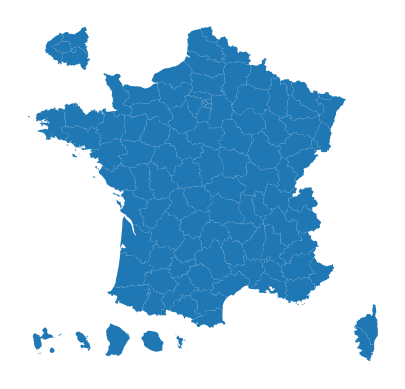

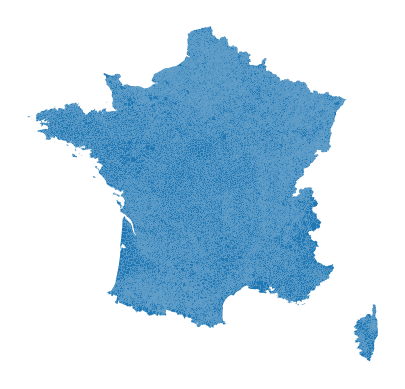

In [15]:
# Test d'affichage des cartes
gdf_departements.plot().axis('off')
gdf_communes.plot().axis('off')

# **II. Statistiques descriptives**

## **1. Étude de l'offre médicale globale en France**

### **1.a. Étude démographique de l'offre médicale en France**

#### **Évolution du nombre de médecins généralistes en France entre 2012 et 2025**

Étudier l’évolution du nombre de médecins généralistes en France entre 2012 et 2025 constitue une approche pertinente pour analyser l’émergence des déserts médicaux. Pour ce faire, nous mobilisons les données relatives à la démographie des professions médicales produites par la DREES.

In [16]:
# Définition d'une fonction pour le diagramme circulaire (ou "pie chart")
def plot_camembert(df, annee, ax, x, y):
    df_annuel = df[[x, y]]

    labels = df_annuel[x].unique()
    sizes = df_annuel[y].unique()

    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(f"{annee}")

In [17]:
# Dans un premier temps, ou souhaite étudier l'évolution du nombre de médecins généralistes en France.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français par année.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['tranche_age']=='00-Ensemble') 
    & (df['region'] == '00-Ensemble')
    & (df['departement'] == '000-Ensemble') 
    & (df['sexe'] == '0-Ensemble')
    & (df['territoire'] == "0-France entière")
    ] 

df

,territoire,region,departement,exercice,tranche_age,sexe,effectif_2012,effectif_2013,effectif_2014,effectif_2015,effectif_2016,effectif_2017,effectif_2018,effectif_2019,effectif_2020,effectif_2021,effectif_2022,effectif_2023,effectif_2024,effectif_2025
0,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,00-Ensemble,0-Ensemble,101435,101385,101904,101935,101799,101755,101939,101381,101355,100621,99941,99457,99009,100019


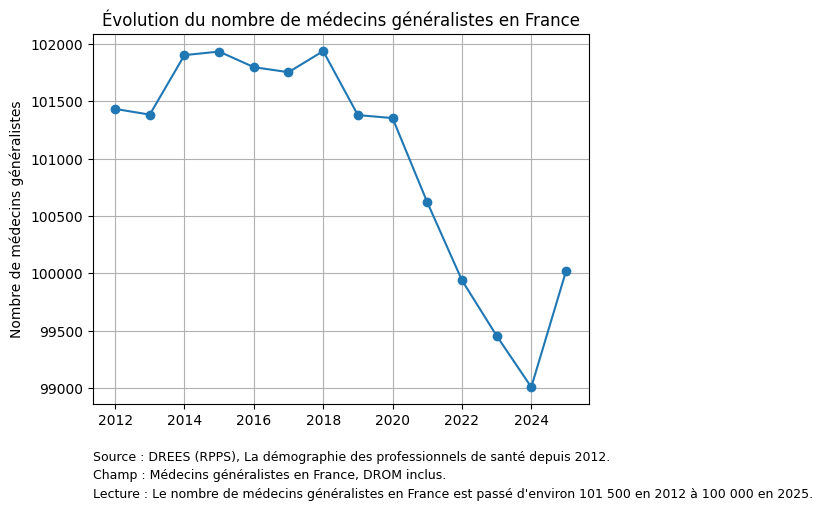

In [18]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026)) 

# 2. Définition des ordonnées : effectifs des années 2012 à 2025.
effectifs = df[[f"effectif_{a}" for a in annees]].values.flatten() 

# 3. Tracé du graphique.
plt.plot(annees, effectifs, marker = "o") 

# 4. Titre et axes.
plt.ylabel("Nombre de médecins généralistes") 
plt.title("Évolution du nombre de médecins généralistes en France") 

# 5. Légende.
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en France est passé d'environ 101 500 en 2012 à 100 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

On observe que le nombre de médecins généralistes en France est resté globalement stable sur la période, autour de 100 000 praticiens (à ± 1 000 près). Dans le même temps, la population française a augmenté d’environ 4 millions d’habitants, ce qui suggère une baisse de la densité médicale par habitant à l’échelle nationale. Toutefois, dans l’étude des déserts médicaux, cette évolution agrégée est moins pertinente que l’analyse des densités médicales à l’échelle territoriale.

#### **Évolution de l'âge moyen des généralistes en France entre 2012 et 2015**

Nous nous intéressons ensuite à l’évolution de l’âge moyen des médecins généralistes. Cette variable est particulièrement pertinente pour anticiper les départs à la retraite d’un corps médical vieillissant, susceptibles de fragiliser le système de santé et de générer de nouveaux déserts médicaux. 

In [19]:
# On s'intéresse à l'évolution de l'âge moyen des MG dans l'ensemble de la France, tous exercices confondus.
df = df_MG_age.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['territoire'] == "0-France entière")
]

df

,territoire,region,departement,exercice,am_2012,am_2013,am_2014,am_2015,am_2016,am_2017,am_2018,am_2019,am_2020,am_2021,am_2022,am_2023,am_2024,am_2025
0,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,51.1,51.4,51.6,51.7,51.7,51.7,51.4,51.3,51.1,51.1,50.8,50.7,50.6,50.4


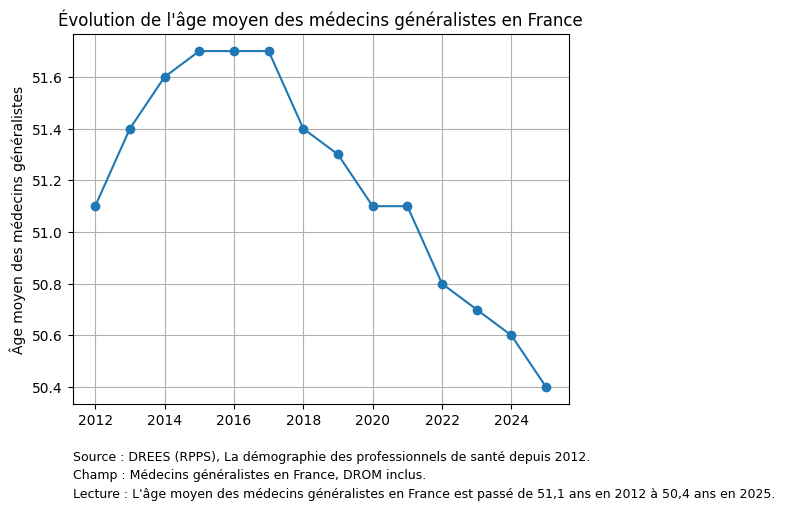

In [20]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026)) 

# 2. Définition des ordonnées : effectifs des années 2012 à 2025.
effectifs = df[[f"am_{a}" for a in annees]].values.flatten() 
plt.plot(annees, effectifs, marker = "o") 

# 3. Titre et axes. 
plt.ylabel("Âge moyen des médecins généralistes") 
plt.title("Évolution de l'âge moyen des médecins généralistes en France") 

# 4. Légende.
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : L'âge moyen des médecins généralistes en France est passé de 51,1 ans en 2012 à 50,4 ans en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

Le graphique de l’âge moyen ne met cependant pas en évidence de tendance marquée : on observe un rajeunissement très limité, de l’ordre de 0,6 an sur l’ensemble de la période, ce qui reste difficilement interprétable en l’état.

#### **Évolution des tranches d'âge des médecin généralistes entre 2012 et 2025**

Afin d’approfondir l’analyse, nous examinons l’évolution de la répartition des médecins généralistes par tranche d’âge. 

In [21]:
# On s'intéresse maintenant à l'évolution des tranches d'âge des médecins généralistes.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français, par année et par tranche d'âge.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['departement'] == '000-Ensemble') 
    & (df['territoire'] == "0-France entière")
    & (df['tranche_age'] != "00-Ensemble")
    & (df['sexe'] == '0-Ensemble')
    ]

# On identifie de nouveaux groupes d'âge.
# 1. On crée une fonction pour attribuer les nouveaux groupes correspondants aux tranches d'âge.
def nouvelle_tranche(tranche):
    if tranche in ["01-moins de 30 ans", "02-entre 30 et 34 ans"]:
        return "1. Moins de 35 ans"
    elif tranche in ["03-entre 35 et 39 ans", "04-entre 40 et 44 ans"]:
        return "2. 35–44 ans"
    elif tranche in ["05-entre 45 et 49 ans", "06-entre 50 et 54 ans"]:
        return "3. 45–54 ans"
    elif tranche in ["07-entre 55 et 59 ans", "08-entre 60 et 64 ans"]:
        return "4. 55–64 ans"
    else:
        return "5. 65 ans et +"

# 2. On somme les effectifs des tranches d'âge au sein du même groupe.
df["nouvelle_tranche_age"] = df["tranche_age"].apply(nouvelle_tranche)
cols_effectifs = [c for c in df.columns if c.startswith("effectif_")]
df = df.groupby("nouvelle_tranche_age")[cols_effectifs].sum().reset_index()

# On renomme les colonnes pour plus de lisibilité.
df.columns = ["Tranche d'âge"] + [f"{a}" for a in range(2012, 2026)]

df

,Tranche d'âge,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,1. Moins de 35 ans,7567,7818,8575,9922,11116,12351,13748,14560,15435,15450,15592,15426,14902,14838
1,2. 35–44 ans,18308,17978,17703,17294,16931,16567,16846,17353,18069,19135,20448,21724,23315,25552
2,3. 45–54 ans,33762,31945,30103,27654,25457,23731,22287,20956,19686,18910,18138,17845,17475,17161
3,4. 55–64 ans,36244,36631,36764,36979,37022,36614,35674,34489,33300,31672,29997,28189,26276,24341
4,5. 65 ans et +,5554,7013,8759,10086,11273,12492,13384,14023,14865,15454,15766,16273,17041,18127


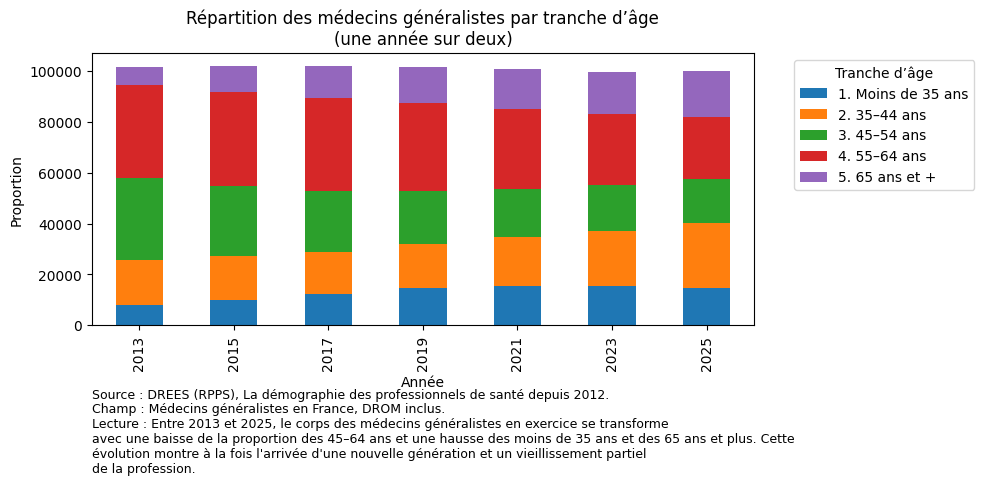

In [22]:
# 1. Définition des abscisses :  années une sur deux entre 2013 et 2025.
annees = list(range(2013, 2026, 2))

cols = [f"{a}" for a in annees]

# 2. On prend la transposée de la base de données pour faire l'histogramme.
df_plot = df.set_index("Tranche d'âge")[cols].T

# 3. Tracé de l'histogramme en barres empilées.
df_plot.plot(kind="bar",stacked=True,figsize=(10, 6))

# 4. Titre et axes.
plt.ylabel("Proportion")
plt.xlabel("Année")
plt.title("Répartition des médecins généralistes par tranche d’âge\n(une année sur deux)")
plt.legend(title="Tranche d’âge", bbox_to_anchor=(1.05, 1))

# 5. Légende.
plt.text(0, -0.28, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.33, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.55, "Lecture : Entre 2013 et 2025, le corps des médecins généralistes en exercice se transforme\n"
    "avec une baisse de la proportion des 45–64 ans et une hausse des moins de 35 ans et des 65 ans et plus. Cette \n"
    "évolution montre à la fois l'arrivée d'une nouvelle génération et un vieillissement partiel \n"
    "de la profession.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.tight_layout()
plt.show()


Ce graphe s’avère beaucoup plus pertinent. Il met en évidence un vieillissement partiel de la profession, caractérisé par une augmentation sensible de la part des médecins âgés de 65 ans et plus encore en activité, qui représentent environ un sixième des généralistes. Autrement dit, en 2025, un médecin généraliste sur six a largement dépassé l’âge légal de départ à la retraite, toutes réformes confondues, ce qui constitue un facteur de risque important pour la stabilité du système de santé. Néanmoins, on observe également l’émergence d’une nouvelle génération de jeunes médecins, atténuant partiellement ce constat.

#### **Évolution de la parité chez les médecins généralistes en France.**

Nous étudions ensuite la question de la parité chez les médecins généralistes.

In [23]:
# On étudie l'évolution de la parité au sein des médecins généralistes.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français, par année et par sexe.
df = df_MG_effectif.copy()

df = df[
    (df['sexe'] != '0-Ensemble')
    & (df['departement'] == '000-Ensemble')
    & (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['territoire'] == "0-France entière")
    & (df['tranche_age'] == "00-Ensemble")
    ]

df.reset_index(drop = True, inplace = True)

df

,territoire,region,departement,exercice,tranche_age,sexe,effectif_2012,effectif_2013,effectif_2014,effectif_2015,effectif_2016,effectif_2017,effectif_2018,effectif_2019,effectif_2020,effectif_2021,effectif_2022,effectif_2023,effectif_2024,effectif_2025
0,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,00-Ensemble,1-Hommes,60035,59183,58644,57634,56579,55556,54550,53146,52255,50936,49754,48754,47822,47567
1,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,00-Ensemble,2-Femmes,41400,42202,43260,44301,45220,46199,47389,48235,49100,49685,50187,50703,51187,52452


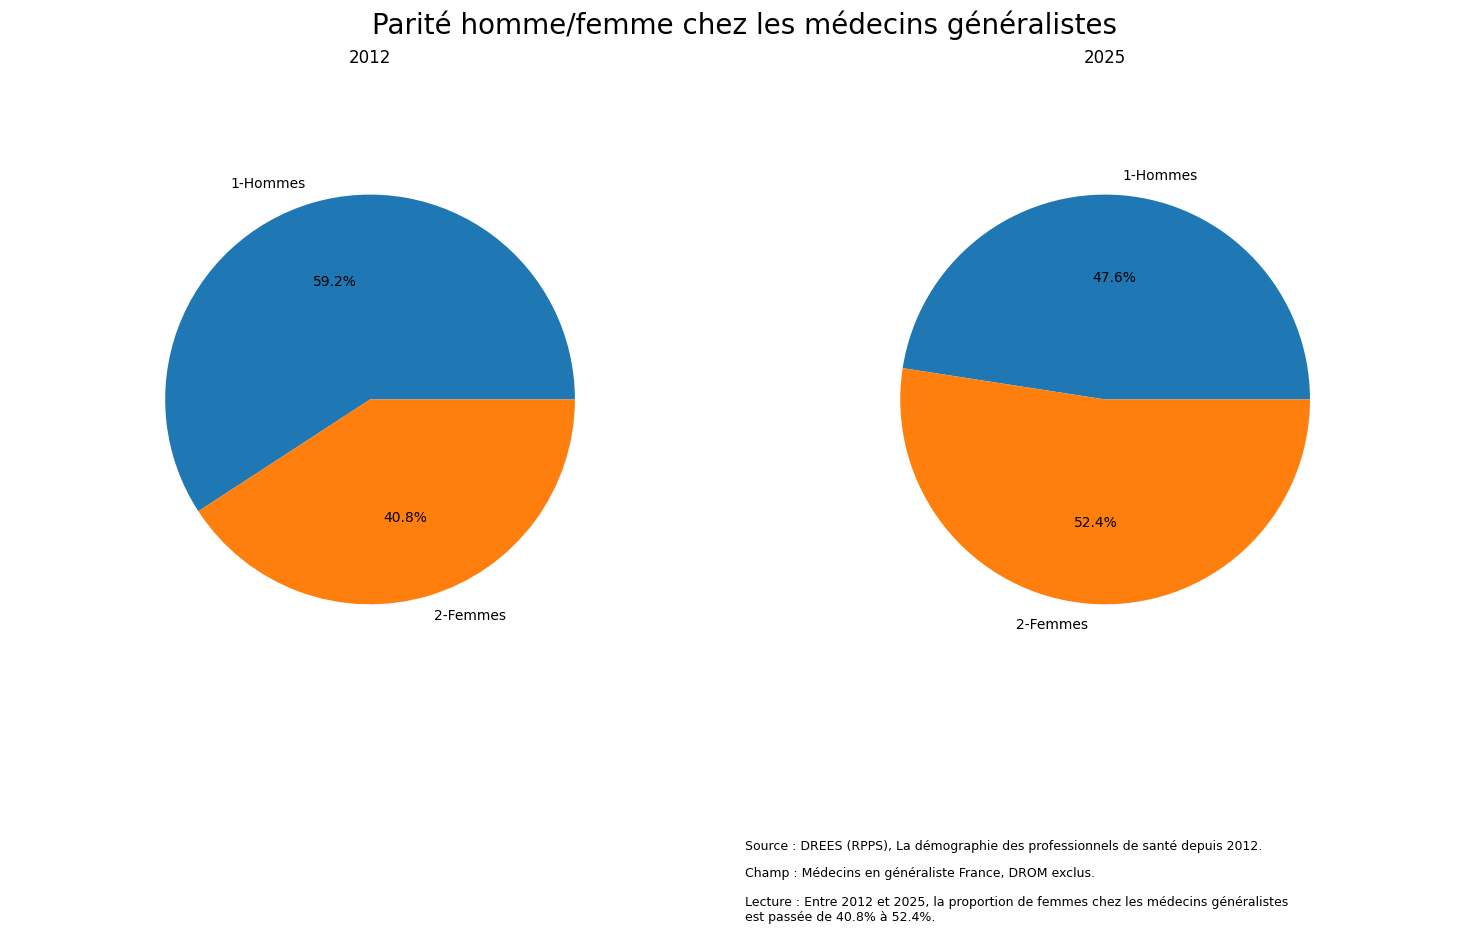

In [24]:
# 1. Définition de la figure (répartition et taille)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# 2. Tracé des graphes
for axe, annee in zip(axes, [2012, 2025]):
    plot_camembert(df, annee, axe, 'sexe', f'effectif_{annee}')

# 3. Titre
fig.suptitle("Parité homme/femme chez les médecins généralistes", fontsize=20, )

# 4. Légende
plt.text(0, -0.19, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.23, "Champ : Médecins en généraliste France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.32,
    "Lecture : Entre 2012 et 2025, la proportion de femmes chez les médecins généralistes\n"
    "est passée de 40.8% à 52.4%. \n",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

 Les données révèlent une progression marquée de la proportion de femmes entre 2012 et 2025, de l’ordre de 12 points de pourcentage. Dans le même temps, le nombre de médecins généralistes hommes recule fortement (−13 000 sur la période), tandis que celui des femmes augmente significativement (+11 500). Ces évolutions confirment des résultats largement documentés dans la littérature, notamment la plus forte propension des hommes à se spécialiser et l’ouverture progressive des études de médecine aux femmes en France.

### **1.b. Étude des spécialisations & sectorisation de l'offre médicale globale en France**

#### **Sectorisation des médecins en France**

Nous nous intéressons enfin aux modes d’exercice des médecins généralistes, dont l’évolution apporte un éclairage important sur la dynamique des déserts médicaux

In [26]:
df_medecins_secteur_réduit= df_medecins_secteur[(df_medecins_secteur['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_secteur['region'] == '00-Ensemble')
    & (df_medecins_secteur['departement'] == '000-Ensemble')
    & (df_medecins_secteur['mode_exercice'] == '0-Ensemble')
    & (df_medecins_secteur['territoire'] == '0-France entière')
    & (df_medecins_secteur['specialites'] == '01-Médecine générale')
    ]
df_medecins_secteur_réduit.head()

,territoire,region,departement,mode_exercice,secteur_activite,specialites,specialites_agregees,activités_2012,activités_2013,activités_2014,...,activités_2016,activités_2017,activités_2018,activités_2019,activités_2020,activités_2021,activités_2022,activités_2023,activités_2024,activités_2025
3,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,00-Ensemble,01-Médecine générale,1-Médecine générale,112701,115011,117635,...,121306,122650,124046,124527,125628,126096,126233,126541,129841,131133
21,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,01-Hôpital public,01-Médecine générale,1-Médecine générale,17618,18373,19202,...,19993,20680,21043,21276,21357,21257,21111,20684,20961,21118
39,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,02-Etablissement privé ESPIC,01-Médecine générale,1-Médecine générale,1597,1671,1682,...,1771,1804,1857,1897,1864,1913,1989,1946,2047,2070
57,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,03-Etablissement privé lucratif,01-Médecine générale,1-Médecine générale,1312,1579,1652,...,1918,2000,2098,2187,2251,2279,2290,2335,2402,2434
75,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,"04-Centre de santé, maison de santé",01-Médecine générale,1-Médecine générale,2792,3228,3480,...,3794,3911,3971,4080,4514,4885,5124,5583,6516,7235


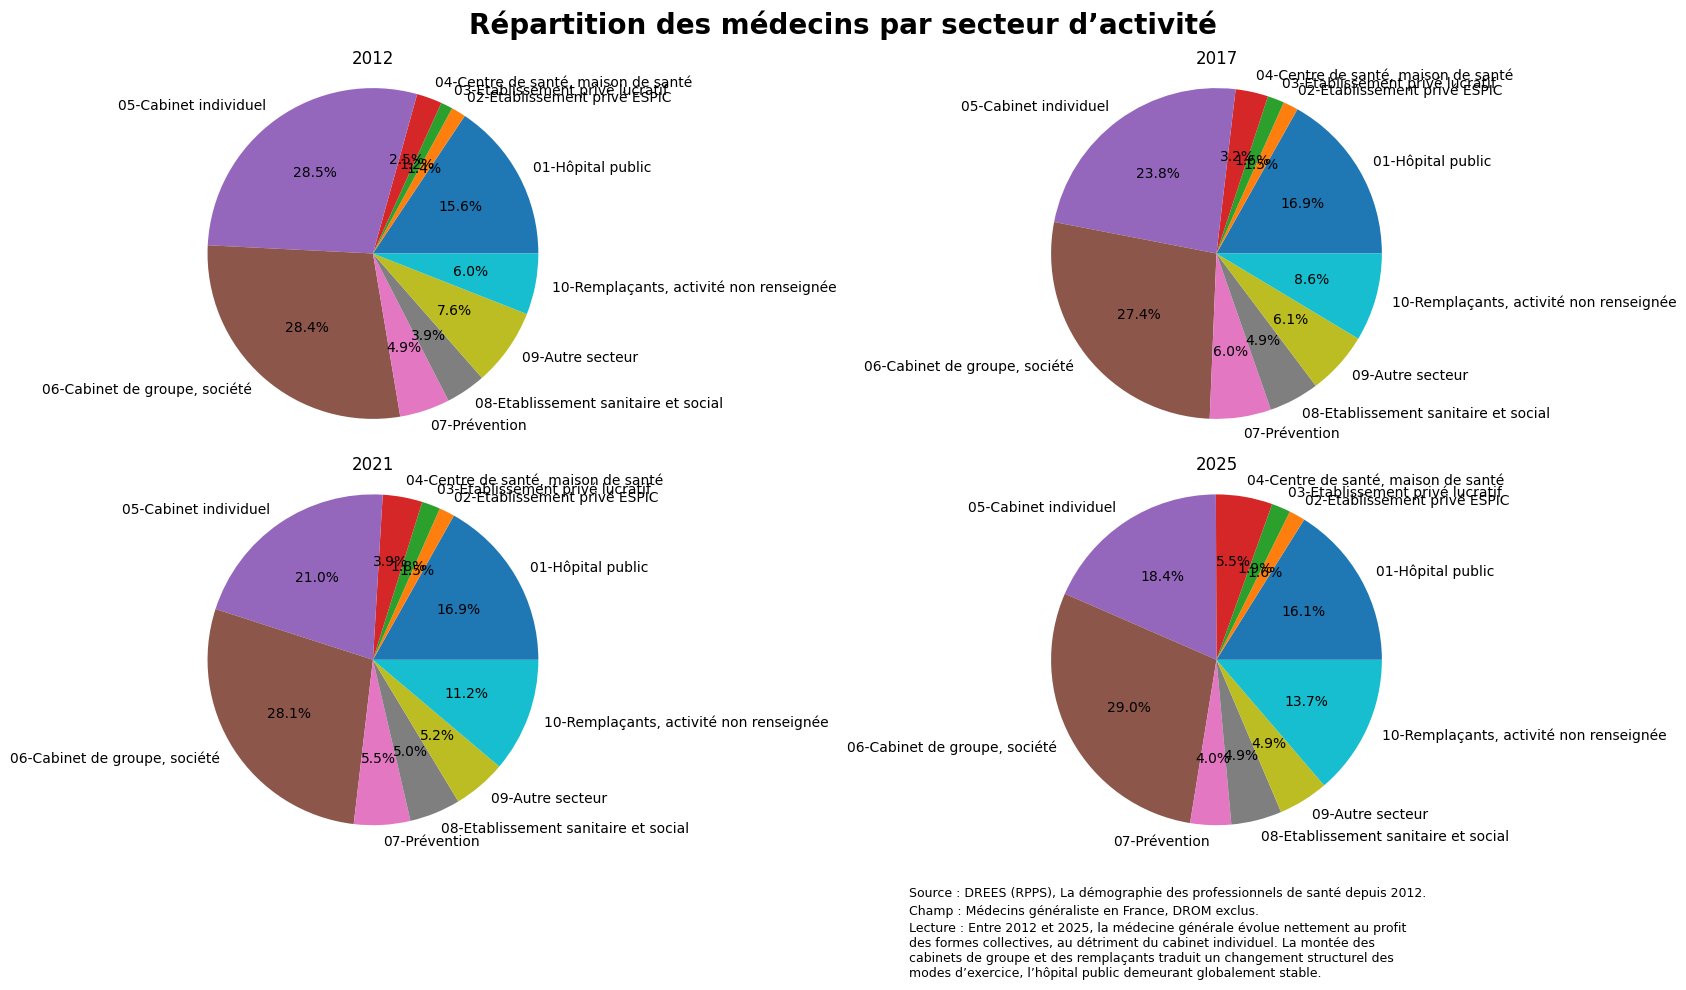

In [27]:
df_medecins_secteur_réduit = df_medecins_secteur_réduit[df_medecins_secteur_réduit["secteur_activite"] != "00-Ensemble"]

# Définition de la figure (répartition & taille)
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Tracé des graphes
for axe, annee in zip(axes.flatten(), [2012, 2017, 2021, 2025]):
    plot_camembert(df_medecins_secteur_réduit, annee, axe, 'secteur_activite',f'activités_{annee}')

# Titre
fig.suptitle("Répartition des médecins par secteur d’activité", fontsize=20, fontweight="bold")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généraliste en France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.38,
    "Lecture : Entre 2012 et 2025, la médecine générale évolue nettement au profit\n"
    "des formes collectives, au détriment du cabinet individuel. La montée des\n"
    "cabinets de groupe et des remplaçants traduit un changement structurel des\n"
    "modes d’exercice, l’hôpital public demeurant globalement stable.",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

On constate un net basculement de l’activité vers des formes d’exercice collectif, au détriment des cabinets individuels. Cette tendance favorise l’émergence de structures centralisées telles que les cabinets de groupe ou les pôles de santé. Si ces organisations peuvent améliorer la coordination des soins, elles contribuent également à renforcer les inégalités territoriales d’accès aux services médicaux.

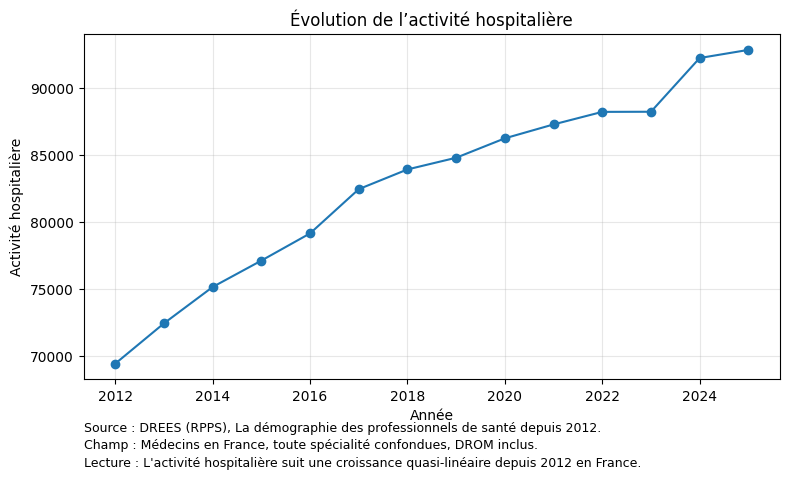

In [28]:
df_hopital = df_medecins_secteur[(df_medecins_secteur["secteur_activite"] == "01-Hôpital public")
    & (df_medecins_secteur["mode_exercice"] == "0-Ensemble")
    & (df_medecins_secteur["departement"] == "000-Ensemble")
    & (df_medecins_secteur["region"] == "00-Ensemble")
    & (df_medecins_secteur["territoire"] == "0-France entière")
    & (df_medecins_secteur["specialites_agregees"] == "00-Ensemble")
    & (df_medecins_secteur["specialites"] == "00-Ensemble")
    ]

# Colonnes d'activité
cols_activite = [c for c in df_hopital.columns if c.startswith("activités_")]

# Années
annees = [int(c.split("_")[1]) for c in cols_activite]


plt.figure(figsize=(8, 5))
plt.plot(annees, df_hopital[cols_activite].iloc[0], marker='o')


plt.xlabel("Année")
plt.ylabel("Activité hospitalière")
plt.title("Évolution de l’activité hospitalière")
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins en France, toute spécialité confondues, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : L'activité hospitalière suit une croissance quasi-linéaire depuis 2012 en France.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Parallèlement, le secteur hospitalier connaît une certaine instabilité. L’évolution de l’activité hospitalière publique, toutes spécialités confondues, apparaît toutefois quasi linéaire depuis 2012, sans rupture majeure sur la période étudiée.

#### **Spécialisation des médecins en France**

In [29]:
df_medecins_specialité = df_medecins_effectif_complet[(df_medecins_effectif_complet['sexe'] == '0-Ensemble')
    & (df_medecins_effectif_complet['departement'] == '000-Ensemble')
    & (df_medecins_effectif_complet['exercice']=='0-Ensemble') 
    & (df_medecins_effectif_complet['region'] == '00-Ensemble') 
    & (df_medecins_effectif_complet['territoire'] == "0-France entière")
    & (df_medecins_effectif_complet['tranche_age'] == "00-Ensemble")
    & (df_medecins_effectif_complet['specialites'] != '00-Ensemble')
    ]

df_medecins_specialité.drop(axis = 1, columns = ['region','specialites_agregees','sexe', 'tranche_age','territoire','departement','exercice'], inplace = True)
df_medecins_specialité.reset_index(drop = True, inplace = True)
df_medecins_specialité.head()

/tmp/ipykernel_4658/3033301306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medecins_specialité.drop(axis = 1, columns = ['region','specialites_agregees','sexe', 'tranche_age','territoire','departement','exercice'], inplace = True)


,specialites,effectif_2012,effectif_2013,effectif_2014,effectif_2015,effectif_2016,effectif_2017,effectif_2018,effectif_2019,effectif_2020,effectif_2021,effectif_2022,effectif_2023,effectif_2024,effectif_2025
0,01-Médecine générale,101435,101385,101904,101935,101799,101755,101939,101381,101355,100621,99941,99457,99009,100019
1,02-Chirurgie,11984,12225,12448,12665,12887,13106,13314,13405,13644,13788,13956,13952,14139,14332
2,03-Ophtalmologie,5760,5817,5820,5865,5881,5900,5853,5821,5850,5826,5794,5749,5825,5981
3,04-Oto-rhino-laryngologie,3018,3043,3059,3042,3061,3048,3022,3006,3023,2999,2996,2963,2937,2933
4,05-Anesthésie-Réanimation,10846,11008,11145,11368,11512,11666,11846,11856,12063,12215,12523,12763,13273,13536


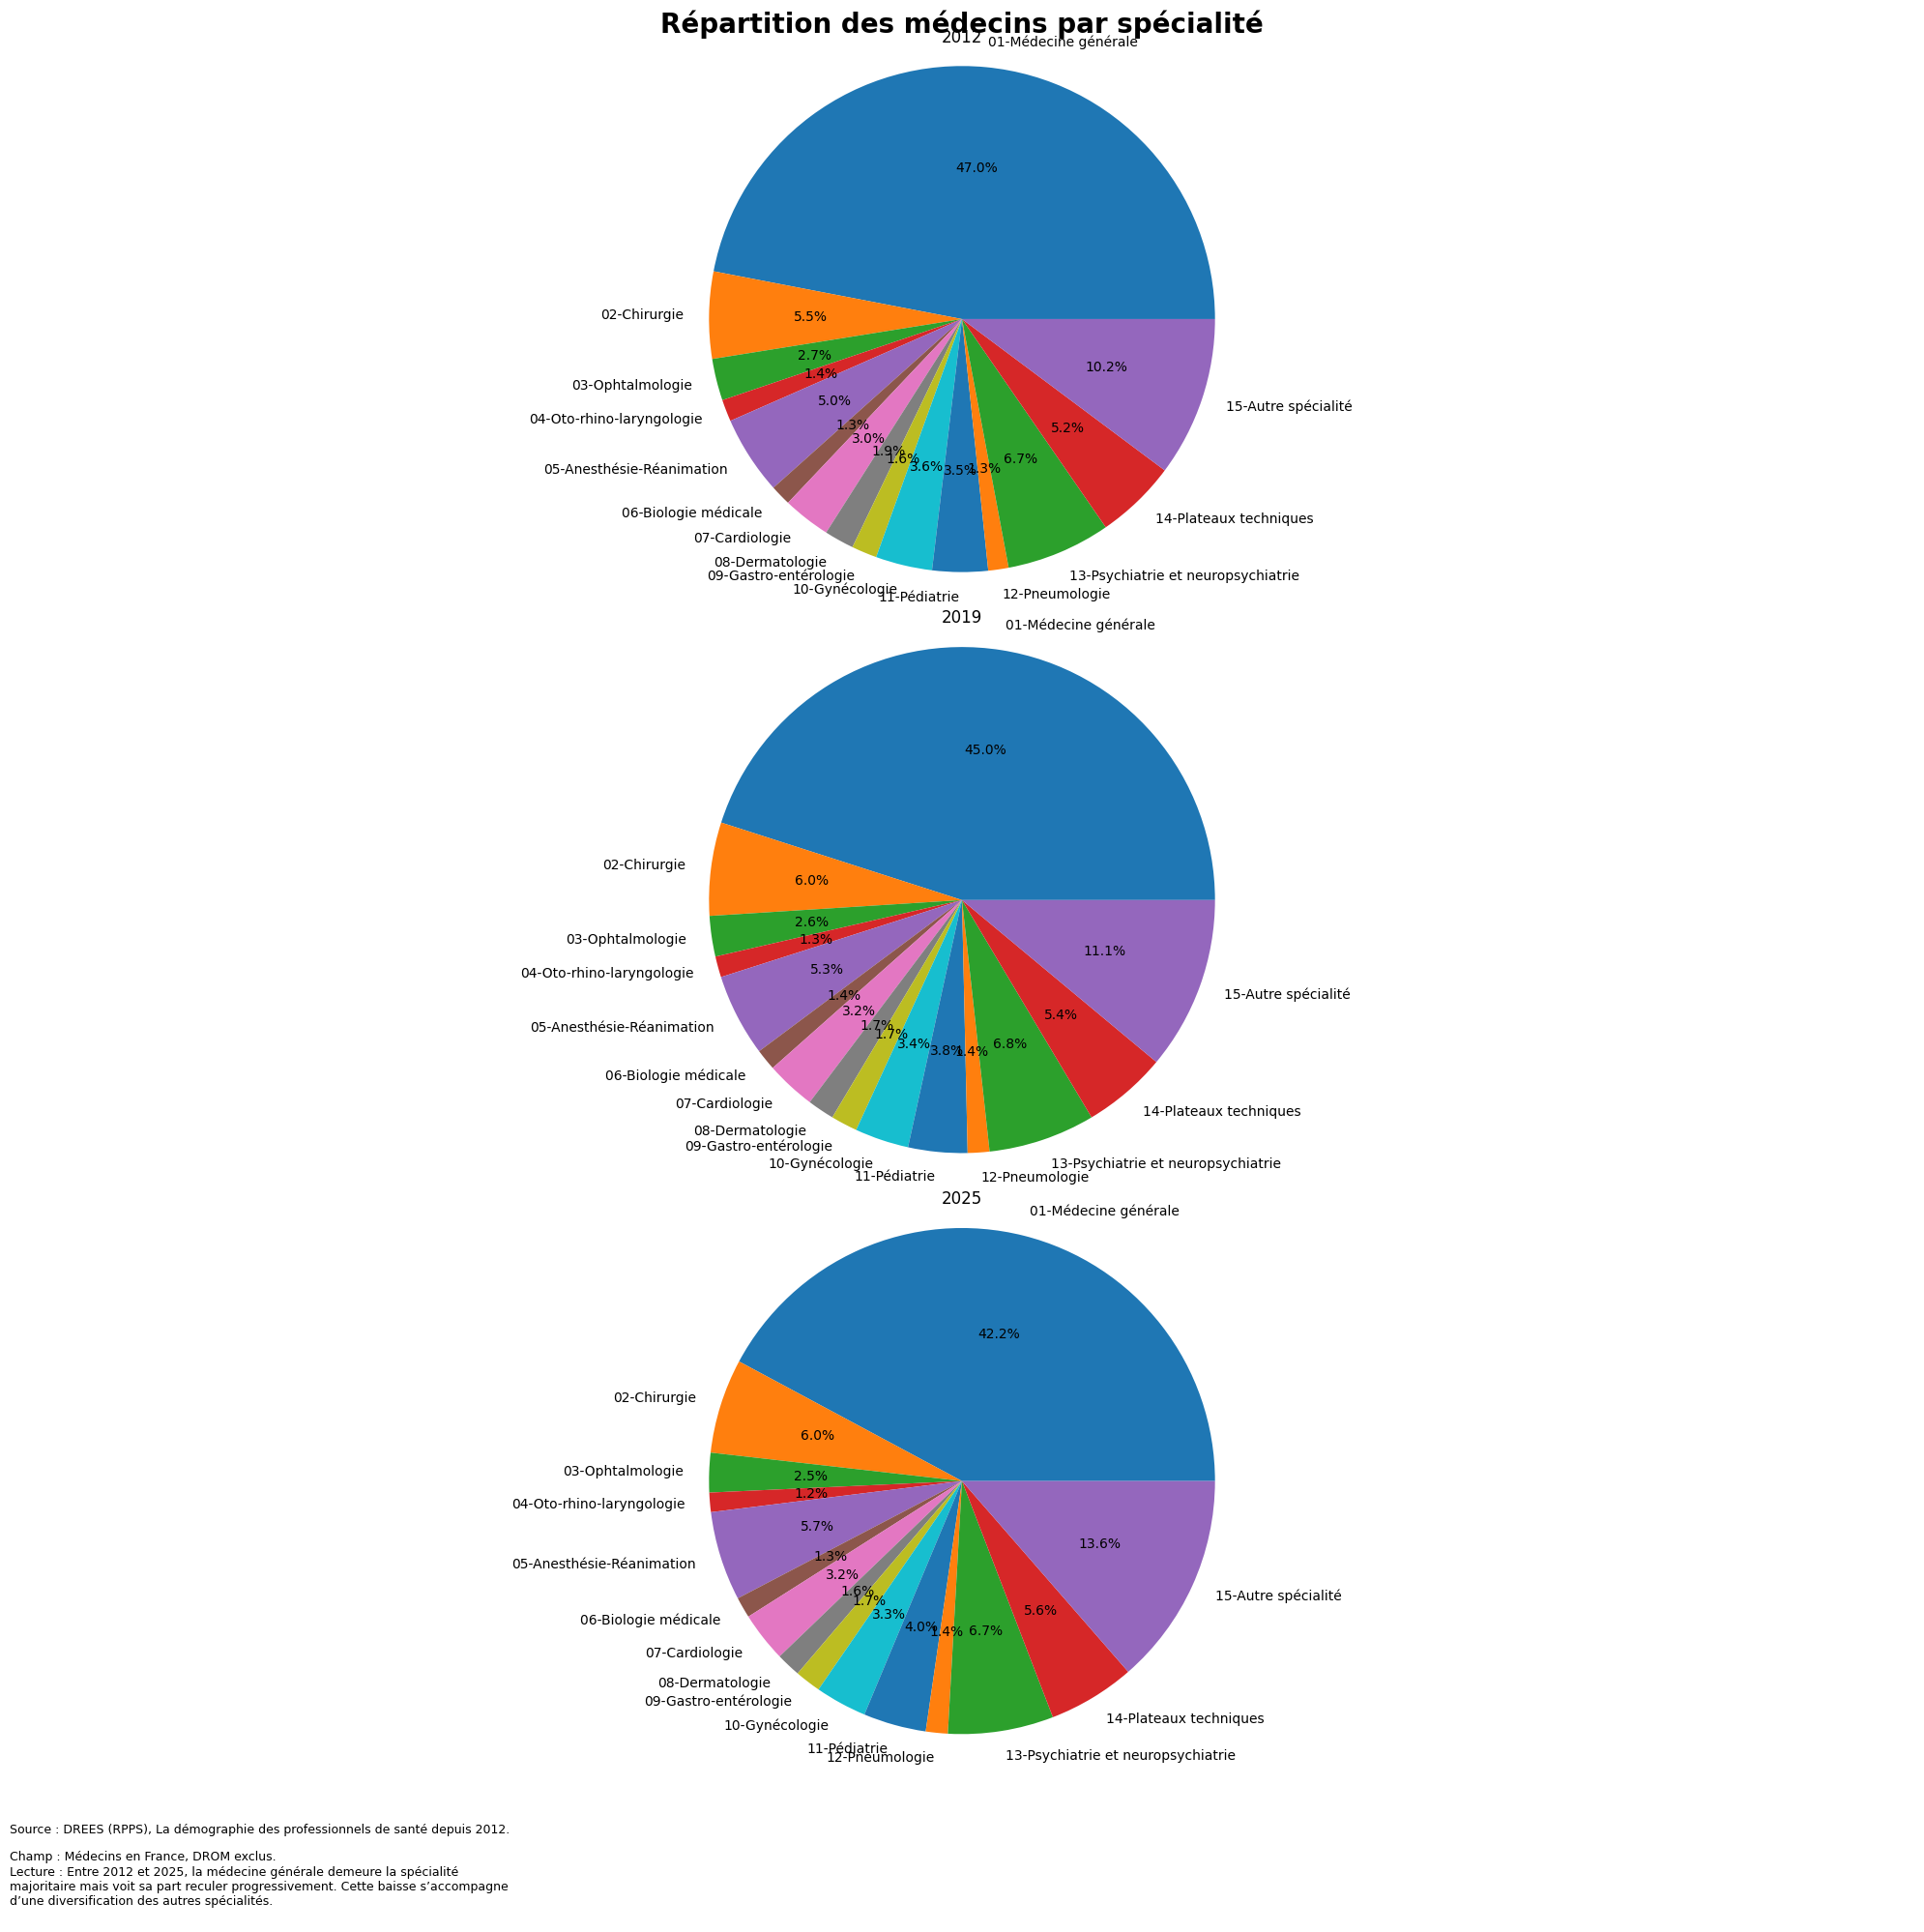

In [30]:
# Définition de la figure (répartition & taille)
fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Tracé des graphes
for axe, annee in zip(axes, [2012, 2019, 2025]):
    plot_camembert(df_medecins_specialité, annee, axe, 'specialites', f'effectif_{annee}')

# Titre
fig.suptitle("Répartition des médecins par spécialité", fontsize=20, fontweight="bold")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins en France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.32,
    "Lecture : Entre 2012 et 2025, la médecine générale demeure la spécialité \n"
    "majoritaire mais voit sa part reculer progressivement. Cette baisse s’accompagne \n"
    "d’une diversification des autres spécialités.\n",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

Enfin, l’analyse des proportions de spécialisation au cours du temps met en évidence un recul relatif de la part des médecins généralistes. À l’inverse, certaines spécialités progressent légèrement, comme l’anesthésie, dont la proportion passe d’environ 5 % à 5,7 % sur la période.

### **1.c. Étude géographique de l'offre médicale en France**

#### **Évolution du nombre de médecins généralistes par région**
On souhaite ici étudier l'existence de tendance ces dernières années vis-à-vis de l'installation des médecins généralistes dans différentes régions. 

Il semblerait que le nombre de médecins généralistes diminue principalement en Île de France. Dans les autres régions, bien que son évolution soit généralement à la baisse, celle-ci semble peu significative. On peut ainsi imaginer que cette évolution n'est pas due à un déplacement des médecins généralistes, mais simplement à la baisse de l'effectif de ces derniers sur le territoire, qui se manifesterait plus fortement en Île de France, la région la plus peuplée.

In [31]:
# On souhaite étudier l'évolution du nombre de médecis généralistes par région.
# On construit une base de données qui contient les effectifs par région par année.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble')
    & (df['tranche_age']=='00-Ensemble') 
    & (df['sexe']=='0-Ensemble')
    & (df['departement']=='000-Ensemble')
    & (df['region'] != '00-Ensemble')
    ]

df.sort_values('region', inplace=True)
df.reset_index(inplace=True, drop=True)

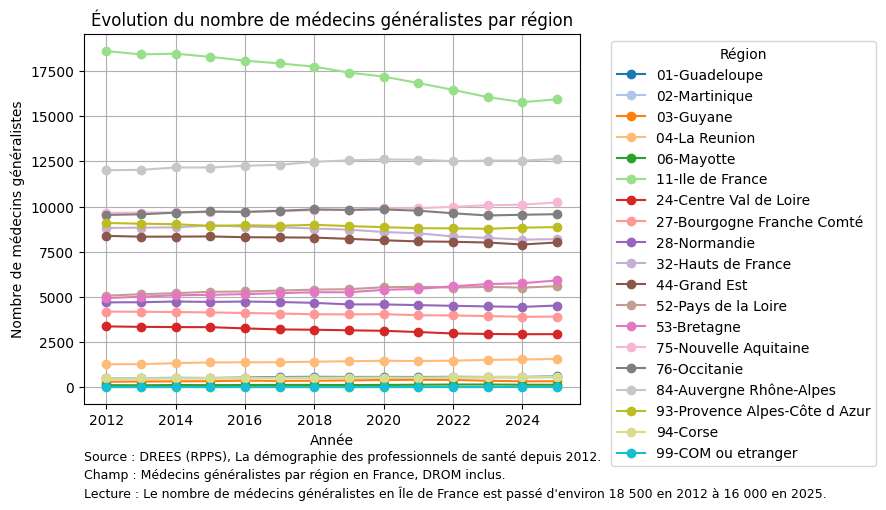

In [32]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026))

# 2. Définition dune palette avec 20 couleurs de manière à ce que chaque région ait une couleur différente.
plt.gca().set_prop_cycle(color=plt.cm.tab20.colors)

# 3. Définition des ordonnées : effectifs par région des années 2012 à 2025.
for region in df['region'].unique() :
    df_region = df[(df['region'] == region) & (df['departement'] == '000-Ensemble')]
    effectifs = df_region[[f"effectif_{a}" for a in annees]].values.flatten()
    plt.plot(annees, effectifs, label = region, marker = "o")

# 4. Titre et axes. 
plt.xlabel("Année")
plt.ylabel("Nombre de médecins généralistes")
plt.title(f"Évolution du nombre de médecins généralistes par région")

# Légende.
plt.legend(title="Région", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes par région en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en Île de France est passé d'environ 18 500 en 2012 à 16 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

## **2. Étude de la répartition des déserts médicaux**

### **1.a. Étude de la densité de médecins en France**

#### **Densité de médecins généralistes par département en 2023**

Nous avons souhaité commencer notre étude géographique par une étude de la densité de médecins généralistes, c'est-à-dire le nombre de médecins généralistes pour 100 000 habitants. La base de la démographie des médecins nous permettaient de réaliser cette carté aisément à l'échelle départementale. Nous aurions souhaité créer une carte interactive pour voir l'évolution de cette variable entre 2012 et 2025, mais n'avons pas réussi à la mettre en oeuvre. Ainsi, nous avons décidé de centrer notre étude sur l'année 2023, afin de pouvoir comparer cette carte à l'indicateur APL de l'année 2023, année la plus récente pour laquelle il était à notre disposition. 

Cette carte révèle de grandes disparités géographiques. Comme l'on pouvait s'y attendre, on remarque des densités plus faibles pour les départements situés sur la diagonale du Nord-Est au Sud-Ouest de la France, qui correspondent à des territoires souvent ruraux avec une population vieillissante. La difficulté de l'accès aux soins dans ces zones a déjà été documentée. On remarque également que les territoires sur le littoral, plus attractifs, sont plus denses en médecins. En Île de France, les médecins sont particulièrement concentrés dans Paris, et moins présents dans les banlieues. Enfin, le département des Hautes-Alpes se distingue par sa densité de médecins, nettement supérieure aux autres départements, même à Paris. 

Cependant, cette première étude est incomplète, car elle ne permet pas de voir les disparités au sein des départements, et notamment de révéler des inégalités entre zones rurales et grandes villes.

In [33]:
# On fait une base de données qui nous donne la densité par département et par année.
df = df_MG_densite.copy()
df = df[(
    df['departement'] != '000-Ensemble') 
    & (df['tranche_age'] == '00-Ensemble')
    & (df['exercice'] == '0-Ensemble')
]

df.reset_index(inplace = True, drop = True)

# On recode la variable du département pour ne garder que le code.
df['departement'] = df['departement'].astype(str).str[:3]

# On recode la variable du département de la base cartiflette pour que les codes correspondent.
departements = gdf_departements.copy()
departements['INSEE_DEP'] = departements['INSEE_DEP'].str.zfill(3)

In [34]:
# Jointure des deux bases sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

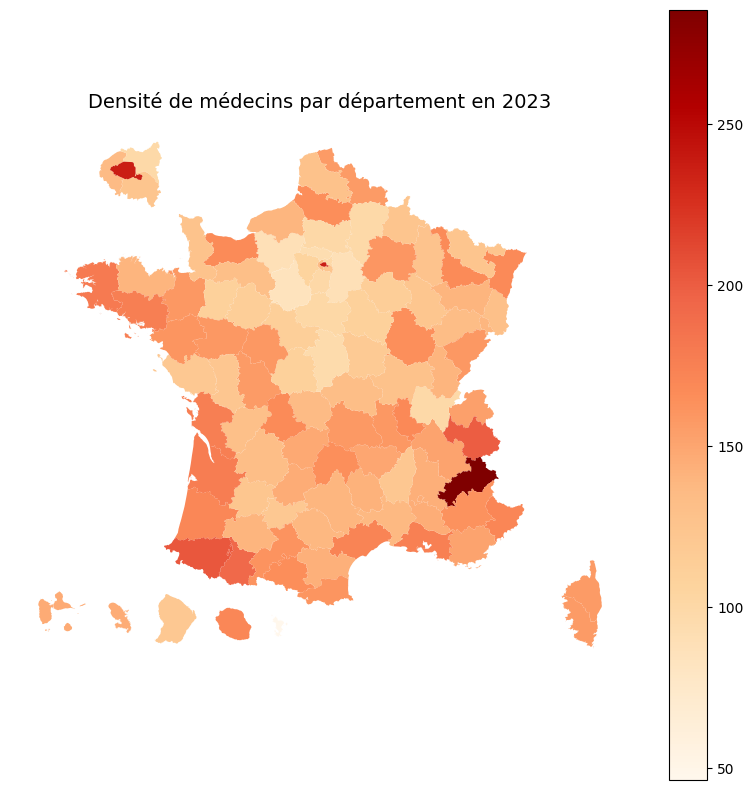

In [35]:
# Tracé de la carte.
fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="densite_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

ax.axis("off")
ax.set_title("Densité de médecins par département en 2023", fontsize=14)

plt.show()

#### **Densité de médecins généralistes par commune en 2024**

On utilise alors la base de données des indicateurs communaux pour estimer la densité de médecins en 2024. Ce nombre n'est pas tout à fait exact, puisque nous ne disposons pas de la population des communes en 2024, mais seulement en 2023. Malgré tout, nous utiliserons cette estimation qui nous semble assez proche du nombre réel, et par ailleurs très intéressante pour notre étude.

Dans un premier temps, nous avons réalisé la carte comme nous l'avions fait précédemment pour les départements. On remarque tout de suite que la valeur particulièrement élevée de la densité de médecins dans une commune des Hautes-Alpes nous empêche de voir l'évolution de la densité dans le du territoire.

Pour pallier ce problème, nous avons utilisé la méthode NaturalBreaks qui permet d'identifier des groupes de valeurs similaires au sein des densités. Cette carte permet de préciser la précédente analyse au niveau départemental : il est désormais d'autant plus clair que les médecins privilégient les littoraux. En effet, les départements concernés sont moins bien dotés dès lors qu'on s'éloigne du littoral. De plus, on remarque que les communes au niveau des Alpes ont effectivement de fortes densités en médecins, particulièrement au niveau de la frontière. Étonnamment, la région parisienne ne ressort pas particulièrement sur la carte. Enfin, la majorité du territoire semble plutôt peu doté en médecin, en particulier sur la diagonale du vide.

In [36]:
# On utilise ici la base des données communales pour avoir la densité par commune.
df = df_pop_communes.copy()
communes = gdf_communes.copy()

# Jointure des bases sur la clé du code de la commue.
communes = communes.merge(df, right_on = 'Code', left_on = 'INSEE_COM')

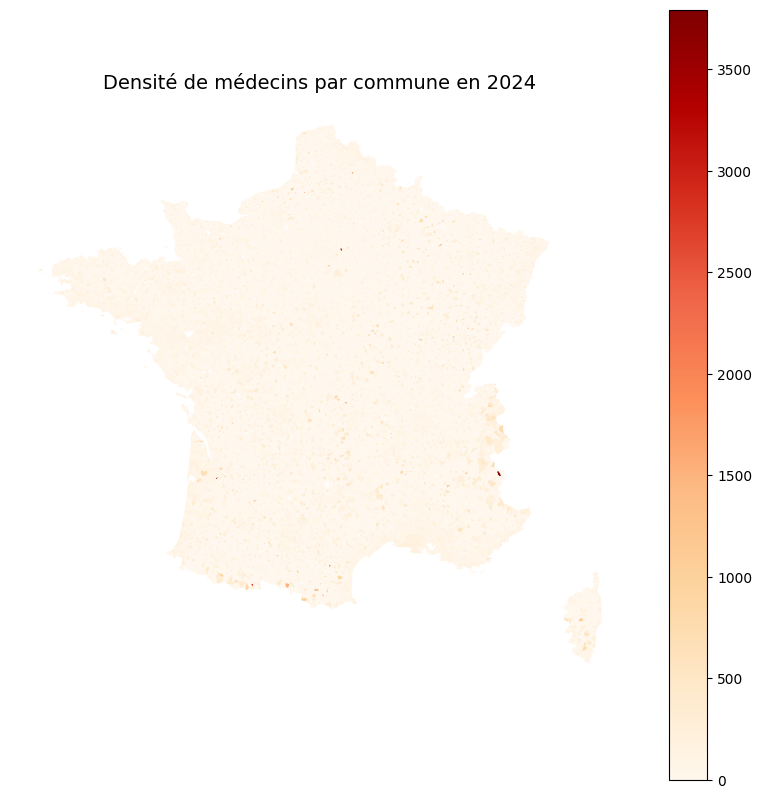

In [37]:
# Tracé de la carte des densités. 
fig, ax = plt.subplots(figsize=(10,10))

# 1. Tracé de la carte.
communes.plot(
    ax=ax,
    column="Densité médecins généralistes 2024",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

# 2. Titre.
ax.axis("off")
ax.set_title("Densité de médecins par commune en 2024", fontsize=14)

plt.show()

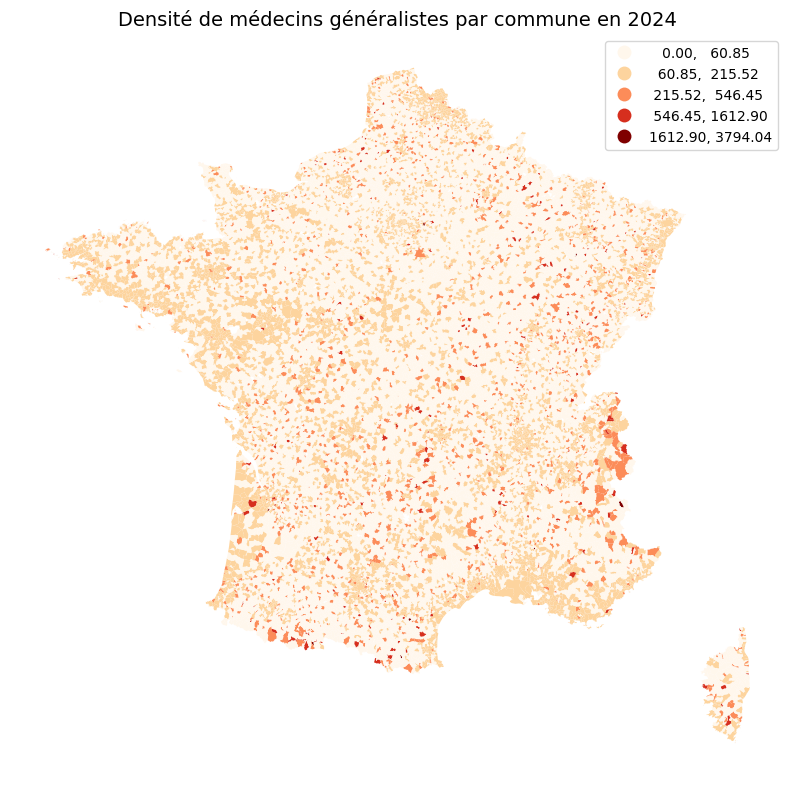

In [38]:
# On constate que certaines valeurs trop importantes empêchent de voir les disparités de densité
# au niveau communal. On utilise NaturalBreaks pour identifier des groupes de densités semblables.
fig, ax = plt.subplots(figsize=(10,10))

# 1. On choisit le nombre de groupes.
n = 5

# 2. Tracé de la carte.
communes.plot(
    ax=ax,
    column="Densité médecins généralistes 2024",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "NaturalBreaks",
    k = n, 
)

# 3. Titre.
ax.axis("off")
ax.set_title("Densité de médecins généralistes par commune en 2024", fontsize=14)

# 4. Légende.
# On affiche les intervalles de valeurs correspondant à chaque groupe.
q = mapclassify.NaturalBreaks(communes['Densité médecins généralistes 2024'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()


### **1.b. Étude de l'indicateur APL en France**

#### **Cartographie de l'indicateur APL par département en 2023**



L'indicateur APL nous permet de réaliser une analyse plus fine des besoins en médecins, parce qu'elle permet de rendre compte de l'accessibilité aux soins, et non pas seulement du nombre de médecins. En effet, en fonction des caractéristiques de la population, notamment de son âge, les besoins en soins de différentes communes ne seront pas forcément les mêmes. Une population plus âgée pourrait en effet nécessiter plus de consultations, et ainsi exercer une pression plus importante sur les médecins disponibles.


Bien que l’indicateur APL par département soit moins intéressant qu’au niveau communal, ce qui permet une analyse plus détaillée, nous avons tout de même souhaité le représenter pour comparer cette carte à celle des densités départementales. La carte de l’indicateur APL montre de moins grandes disparités parmi les départements les mieux dotés : le département des Hautes-Alpes ne ressort plus autant que précédemment, et est comparable en termes d’accessibilité aux soins à Paris, à la Gironde ou au Bas-Rhin, avec autour de 5 consultations accessibles par habitant par an.
En revanche, les départements autour de la Petite Couronne ont un accès aux soins particulièrement limités, ainsi que des départements du centre de la France comme le Cher, avec en moyenne 2 consultations accessibles par habitant par an.

In [39]:
# On ne s'intéresse ici qu'à l'indicateur au niveau agrégé du département : on ne conserve qu'une ligne par département.
df = df_APL.copy()
df.drop_duplicates('departement', inplace = True)

departements = gdf_departements.copy()

# Jointure des deux tables sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

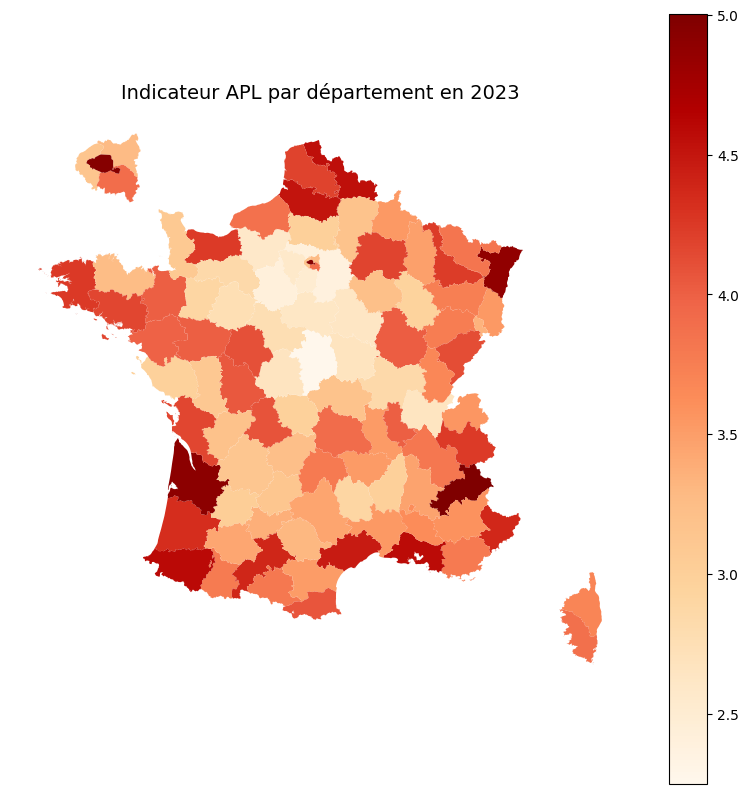

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

# 1. Tracé de la carte.
departements.plot(
    ax=ax,
    column="APL_dep_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

# 2. Titre.
ax.axis("off")
ax.set_title("Indicateur APL par département en 2023", fontsize=14)

plt.show()

#### **Cartographie de l'indicateur APL par commune en 2023**

Comme pour la densité au niveau communal, on décide d'utiliser NaturalBreaks afin de rendre plus facile la lecture de l'indicateur.

Au niveau communal, on remarque un très bon accès aux soins au niveau des Alpes ainsi qu’au bord de l’Atlantique et de la Méditerranée, suivant la tendance montrée par la carte des densités de médecins. Le nord de la France ressort également de par sa bonne accessibilité aux soins, notamment au niveau de Lille et d’Amiens,qui ressortaient moins lorsque l’on considérait les densités. Là où la diagonale du vide et la banlieue lointaine de Paris semblaient comparables en termes de densité, l’APL rend plus évident les différences d’accessibilité aux soins. En effet, la diagonale du vide connaît de nombreux endroits parfaitement blancs, qui montre les difficultés de cette région en matière de soins.

In [41]:
df = df_APL.copy()
communes = gdf_communes.copy()

# Jointure des deux bases sur la clé du code de la commune.
communes = communes.merge(df, left_on = "INSEE_COG", right_on = "Code commune INSEE", how="left")
communes = communes.to_crs(2154)

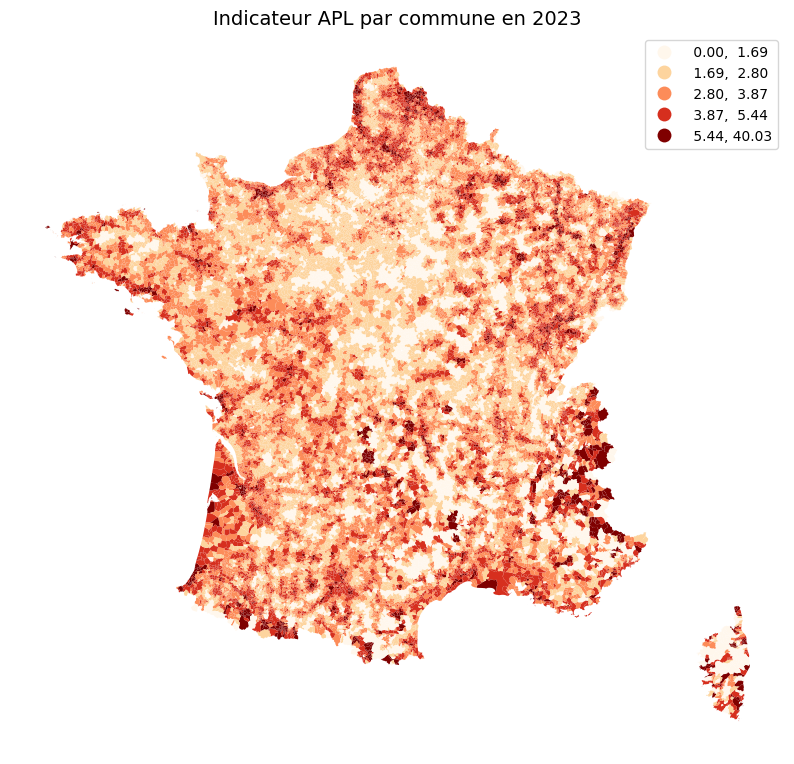

In [42]:
# Ici encore, on décide d'utiliser NaturalBreaks pour éviter que certaines valeurs trop importantes
# de l'indicateur ne rendent difficile la lecture de la carte.
fig, ax = plt.subplots(figsize=(10,10))

# 1. On choisit le nombre de groupes. 
n = 5

# 2. Tracé de la carte.
communes.plot(
    ax=ax,
    column="APL_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "NaturalBreaks",
    k = n
)

# 3. Titre.
ax.axis("off")
ax.set_title("Indicateur APL par commune en 2023", fontsize=14)

# 4. Légende.
q = mapclassify.NaturalBreaks(communes['APL_2023'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

### **1.c. Étude de la patientèle des médecins généralistes en France**

#### **Cartographie du nombre de patients uniques par médecin selon le département en 2023**

In [43]:
# On s'intéresse à la patientèle des médecins généralistes pour l'année 2023, afin d'être comparable à nos autres cartes.
df = df_patientele.copy()
departements = gdf_departements.copy()

df = df[
    (df['annee'] == 2023)
    & (df['profession_sante'] == 'Ensemble des médecins généralistes')]

# On supprime les lignes qui ne correspondent pas à des départements français.
mask = df['departement'].isin(['999'])
df = df[~mask]
df.reset_index(drop = True, inplace = True)

# Jointure des bases de données sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

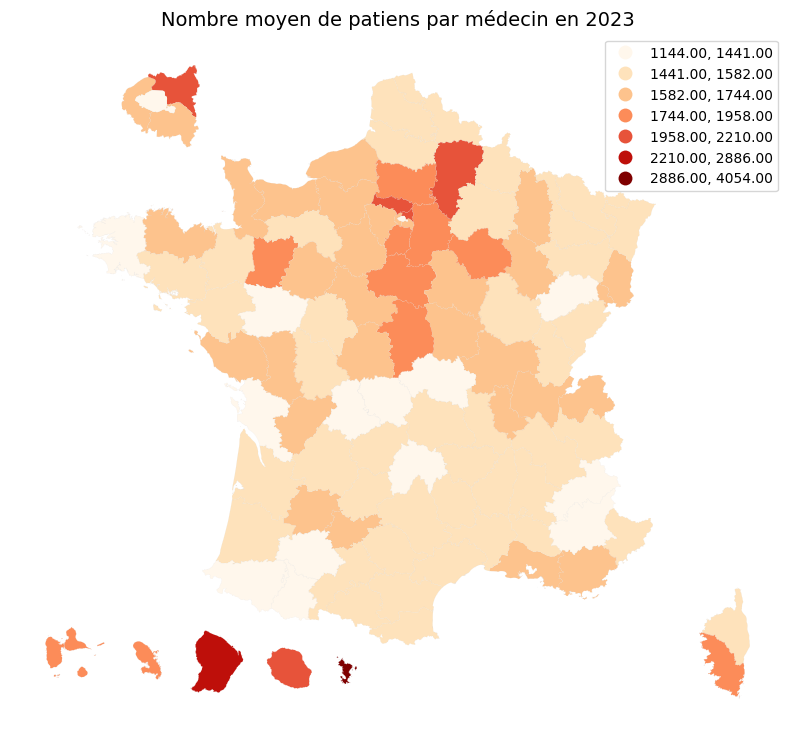

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

# 1. Choix du nombre de groupes
n = 7

# 2. Tracé de la carte.
departements.plot(
    ax=ax,
    column="nombre_patients_uniques",
    cmap="OrRd",               
    linewidth=0.05,
    legend=True,
    scheme = 'NaturalBreaks',
    k=n,
    edgecolor="lightgrey", 
)

# 3. Titre.
ax.axis("off")
ax.set_title("Nombre moyen de patiens par médecin en 2023", fontsize=14)

# 4. Légende.
q = mapclassify.NaturalBreaks(communes['APL_2023'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

# **III. Modélisation**

## **1. Régression de l'APL en fonction de la densité de médecins généralistes**

### **1.a. Par commune, pour l'année 2023**

In [45]:
# On réarrange les tables APL densités de médecins
df1 = df_APL.copy()

df2 = df_pop_communes.copy()

df = df2.merge(df1, left_on = 'Code', right_on='Code commune INSEE')
df.reset_index(drop = True, inplace = True)

<Axes: xlabel='Densité médecins généralistes 2024', ylabel='APL_2023'>

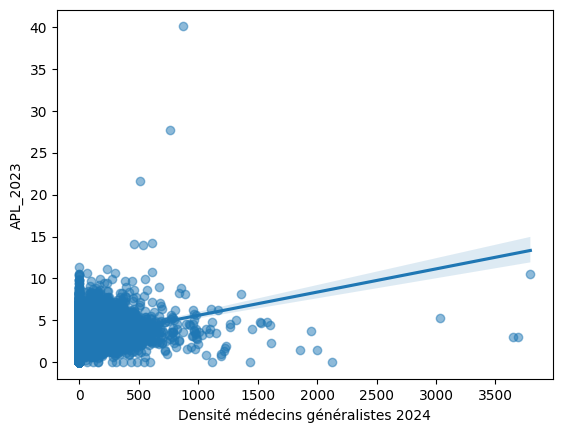

In [46]:
sns.regplot(
    data = df,
    x = 'Densité médecins généralistes 2024',
    y = 'APL_2023',
    fit_reg = True,
    scatter_kws={'alpha':0.5}
)

### **1.b. Par départment, toutes années confondues**

In [47]:
# On formalise le code du département pour éviter des erreurs.
df1 = df_APL.copy()
df1['departement'] = df1['departement'].str.zfill(3)

df2 = df_MG_densite.copy()
df2 = df2[(df2['departement'] != '000-Ensemble') 
    & (df2['tranche_age'] == '00-Ensemble')
    & (df2['exercice'] == '1-Libéral')]
df2['departement'] = df2['departement'].astype(str).str[:3]

# On ne conserve qu'une ligne par département pour la base APL.
df1.drop_duplicates('departement', inplace = True)

In [48]:
# On transforme les tables larges en tables longues de manière à pouvoir faire la régression en utilisant les données de toutes les années.
annees = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
APL = [f"APL_dep_{annee}" for annee in annees]
densite = [f"densite_{annee}" for annee in annees] 

# Pour la base des APL :
df1_long = df1.melt(
    id_vars = ['departement'], 
    value_vars = APL, 
    var_name = 'annee',
    value_name = 'APL'
)

df1_long['annee'] = df1_long['annee'].astype(str).str[8:]

# Pour la base des densités :
df2_long = df2.melt(
    id_vars = ['departement'], 
    value_vars = densite, 
    var_name = 'annee',
    value_name = 'densite' 
)

df2_long['annee'] = df2_long['annee'].astype(str).str[8:]

# On joint les deux tables
df = pd.merge(df2_long, df1_long, on=['departement', 'annee'])

<Axes: xlabel='densite', ylabel='APL'>

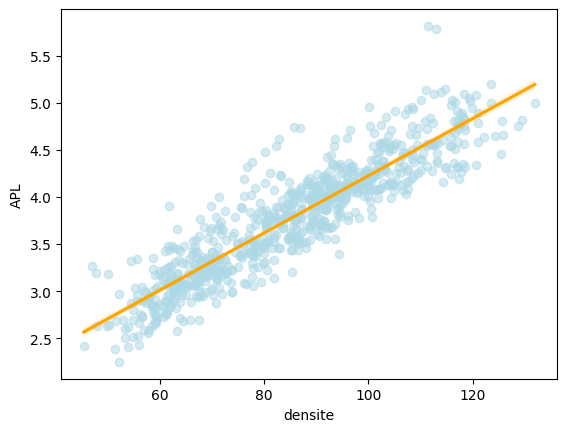

In [49]:
# Régression utilisant les données toutes années confondues
sns.regplot(
    data = df,
    x = 'densite',
    y = 'APL',
    fit_reg = True,
    scatter_kws={'alpha':0.5},
    color="lightblue", line_kws=dict(color="orange")
)

## **2. Régression du nombre de médecins par commune en fonction des indicateurs communaux**

### **1.a. Matrice de corrélation des variables**

In [50]:
# Fonction pour faire une matrice de corrélation des variables.
def plot_corr_heatmap(
    df: pd.DataFrame,
    drop_cols=None,
    column_labels: dict | None = None,
    decimals: int = 2,
    width: int = 600,
    height: int = 600,
    show_xlabels: bool = False
):
    data = df.copy()

    # 1. Colonnes à drop
    if drop_cols is not None:
        data = data.drop(columns=drop_cols)

    # 2. Arrondi + renommage éventuel
    if column_labels is not None:
        data = data.rename(columns=column_labels)
    data = data.round(decimals)

    # 3. Matrice de corrélation
    corr = data.corr()

    # 4. Masque triangle supérieur
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr_masked = corr.mask(mask)

    # 5. Heatmap Plotly
    fig = px.imshow(
        corr_masked.values,
        x=corr.columns,
        y=corr.columns,
        color_continuous_scale='RdBu_r',  # échelle inversée
        zmin=-1,
        zmax=1,
        text_auto=".2f"
    )

    # 6. Hover custom
    fig.update_traces(
        hovertemplate="Var 1: %{y}<br>Var 2: %{x}<br>Corr: %{z:.2f}<extra></extra>"
    )

    # 7. Layout
    fig.update_layout(
        coloraxis_showscale=False,
        xaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        yaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(t=10, b=10, l=10, r=10),
        width=width,
        height=height
    )

    return fig

In [51]:
# On trace la matrice des corrélations des indicateurs communaux.
# On enlève la variable de densité des médecins, qui est calculée à partir de la variable que l'on cherche à expliquer.
df = df_pop_communes.copy().drop(columns=["Code", "Libellé", "departement", "Densité médecins généralistes 2024"])
plot_corr_heatmap(df)

### **1.b. Application de la méthode Lasso pour identifier les variables significatives**

In [52]:
# Fonction pour extraire les coefficients sélectionnés par Lasso.
def extract_features_selected(lasso: Pipeline, preprocessing_step_name: str = 'preprocess') -> pd.Series:
    # Check if lasso object is provided
    if not isinstance(lasso, Pipeline):
        raise ValueError("The provided lasso object is not a scikit-learn pipeline.")
    
    # Extract the final transformer from the pipeline
    lasso_model = lasso[-1]

    # Check if lasso_model is a Lasso regression model
    if not isinstance(lasso_model, Lasso):
        raise ValueError("The final step of the pipeline is not a Lasso regression model.")

    # Check if lasso model has 'coef_' attribute
    if not hasattr(lasso_model, 'coef_'):
        raise ValueError("The provided Lasso regression model does not have 'coef_' attribute. "
                         "Make sure it is a trained Lasso regression model.")

    # Get feature names from the preprocessing step
    features_preprocessing = lasso[preprocessing_step_name].get_feature_names_out()

    # Extract selected features based on non-zero coefficients
    features_selec = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])

    return features_selec

#### **Séparation de la base en une base d'entraînement et une base de test**

In [53]:
# Définition de X (variables explicatives) et y (cible)
X = df.drop(columns=["Médecin généraliste (en nombre) 2024"]) 
y = df["Médecin généraliste (en nombre) 2024"]

# Séparation de la base en une base d'entraînement et une base de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifier les lignes où la valeur du nombre de médecins est manquante
mask = y_train.isna()

# Supprimer ces lignes de y_train et de X_train 
y_train = y_train[~mask]
X_train = X_train[~mask]

#### **Paramètre optimal**

In [54]:
# On applique l'imputation : on bouche les NaN avec la moyenne.
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_train)

# On applique la standardisation pour que les variables soient comparables.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Liste de valeurs du paramètre alpha à tester.
alphas = [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0]

# On cherche la valeur du paramètre qui permet la meilleure prédiction.
# On augmente le nombre maximum d'itérations suite à la mise en garde de python sur la convergence de l'objectif.
# Cela nous permet de n'avoir plus que 3 messages de mise en garde, probablement liés aux faibles valeurs du paramètres, au lieu d'en avoir pour toutes.
lcv = (
  LassoCV(
    alphas = alphas,
    max_iter = 10000,
    fit_intercept = False,
    random_state = 0,
    cv = 5
    ).fit(
      X_scaled, y_train
    )
)

print("alpha optimal :", lcv.alpha_)

/opt/python/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.703e+04, tolerance: 9.661e+02

/opt/python/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e+04, tolerance: 1.139e+03

/opt/python/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.173e+03, tolerance: 1.175e+03



alpha optimal : 0.25


#### **Variables sélectionnées et coefficients associés**

In [55]:
# On applique Lasso en utilisant la valeur optimale de alpha.
# Pipeline : remplace les valeurs manquantes avec des moyennes et standardise les variables.
pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', pipeline, X_train.columns)]
        )

# Pipeline finale
pipeline_finale = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=lcv.alpha_))
])

# On applique le modèle.
lasso_optimal = pipeline_finale.fit(X_train,y_train)

In [56]:
# On accède au modèle.
lasso_model = pipeline_finale['model']

# On récupère le nom des colonnes.
feature_names = pipeline_finale['preprocessor'].get_feature_names_out()

# On affiche les variables sélectionnées par Lasso.
coeffs = pd.Series(lasso_model.coef_, index=feature_names)
print("Variables sélectionnées (coeff != 0) :")
print(coeffs[coeffs != 0])

Variables sélectionnées (coeff != 0) :
num__Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Artisans, commerçants, chefs entreprise    4.738895
num__Boulangerie-pâtisserie (en nombre) 2024                                                                                          3.051357
num__École maternelle, primaire, élémentaire (en nombre) 2024                                                                         0.306890
num__Lycée (en nombre) 2024                                                                                                           2.020251
num__Population municipale 2023                                                                                                       7.099902
num__Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Ensemble                                   2.224812
num__Nb de ménages fiscaux 2021                                                                        